# Algoritmo genetico para optiomizacion de portafolios multiactivo (sectores)

- German Andrés Álvarez López 
- Carlos Andrés Castro Marín 
- Jonathan Javier Montes Castro 
- Karla Victoria Torres Parra

In [1]:
from geneticalgorithm import geneticalgorithm as ga
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier

## Data

In [2]:
#Creamos una lista con los tickers a descargar
# XLE: Energy Select Sector
# XLF: Financial Select Sector
# XLV: Health Care Select Sector
# XLK: Technology Select Sector
# XLU: Utilities Select Sector
# XLI: Industrial Select Sector 
# XLP: Consumer Staples Select Sector
# XLC: Communication Services Select Sector

sectores = ['XLE', 'XLF', 'XLV','XLK','XLU','XLI','XLP','XLC']
start = '2020-01-01'
end = '2023-01-01'
#Descargamos el precio de cierre de lo tickers seleccionados 
precios = yf.download(sectores, start, end)['Adj Close']
#Convertimos a datetime object el resultado con pandas
precios.index = pd.to_datetime(precios.index)

# calculo de los retornos diarios 
retornos_diarios = precios.pct_change()

# Datos de entrada
retornos_anuales = ((1+retornos_diarios.mean())**(252))-1 # Retornos esperados anualizados
covarianzas = retornos_diarios.cov()*252 # matriz de covarianza anualizada
tasa_libre_riesgo = 0.034  # Yield to maturity de los bonos del tesoro de EEUU en el nodo de 10 años

[*********************100%***********************]  8 of 8 completed


In [3]:

# Función objetivo para maximizar el Sharpe Ratio de la cartera con penalización por restricciones
def funcion_objetivo(individuo):
    # Calcula el rendimiento y la desviación estándar de la cartera para un individuo dado
    rendimiento_cartera = individuo@retornos_anuales
    volatilidad_cartera =  np.sqrt(individuo.T@covarianzas@individuo)
    
    # Calcula el Sharpe Ratio de la cartera
    sharpe_ratio = (rendimiento_cartera - tasa_libre_riesgo) / volatilidad_cartera
    
    # Aplica penalización por restricciones
    suma_pesos = np.sum(individuo)
    penalizacion = (100+500) * np.abs(suma_pesos - 1.0)  # Penalización por desviarse de la suma de pesos igual a 1
    
    return -sharpe_ratio + penalizacion  # Se multiplica por -1 para maximizar



## Algotirmo genetico para optimizacion 

 The best solution found:                                                                           
 [0.10794038 0.09732279 0.177808   0.11725514 0.02376985 0.00452022
 0.37014729 0.10122411]

 Objective function:
 -0.3484819772362157


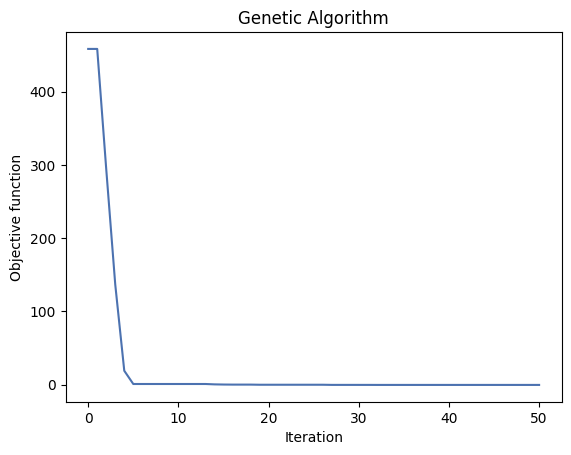

In [4]:
# Parámetros del algoritmo genético

algorithm_param = {'max_num_iteration': 50,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.3,\
                   'crossover_probability': 0.9,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound=np.array([(0, 1)] * len(sectores))

# Crear el objeto de optimización del algoritmo genético
modelo_genetico = ga(function=funcion_objetivo, 
                     dimension=len(sectores), 
                     variable_type='real', 
                     variable_boundaries=varbound,
                     algorithm_parameters=algorithm_param,
                     )



# Ejecutar el algoritmo genético
modelo_genetico.run()

# Obtener el resultado óptimo
mejor_individuo = modelo_genetico.output_dict['variable']

lista = mejor_individuo.tolist()
diccionario = {sectores[i]: lista[i] for i in range(len(sectores))}

rendimiento_mejor_individuo = mejor_individuo@retornos_anuales
volatilidad_mejor_individuo = np.sqrt(mejor_individuo.T@covarianzas@mejor_individuo)
sharpe_ratio_mejor_individuo = (rendimiento_mejor_individuo - tasa_libre_riesgo) / volatilidad_mejor_individuo

In [5]:
# Generacion de 10 optimizaciones

pesos = pd.DataFrame(index=sectores)
m_rend = []
m_vol = []
m_s = []
for i in range (10):
    # Crear el objeto de optimización del algoritmo genético
    modelo_genetico = ga(function=funcion_objetivo, 
                     dimension=len(sectores), 
                     variable_type='real', 
                     variable_boundaries=varbound,
                     algorithm_parameters=algorithm_param,
                     convergence_curve=False
                     )

    
    
    modelo_genetico.run()

    # Obtener el resultado óptimo
    mejor_individuo = modelo_genetico.output_dict['variable']

    lista = mejor_individuo.tolist()
    diccionario = {sectores[i]: lista[i] for i in range(len(sectores))}

    rendimiento_mejor_individuo = mejor_individuo@retornos_anuales
    volatilidad_mejor_individuo = np.sqrt(mejor_individuo.T@covarianzas@mejor_individuo)
    sharpe_ratio_mejor_individuo = (rendimiento_mejor_individuo - tasa_libre_riesgo) / volatilidad_mejor_individuo
    
    #almacenamiento
    h = 'iteracion '+ str(i)
    pesos[h] = mejor_individuo
    
    m_rend.append(rendimiento_mejor_individuo)
    m_vol.append(volatilidad_mejor_individuo)
    m_s.append(sharpe_ratio_mejor_individuo)

consolidado_performance = pd.DataFrame(columns=pesos.columns,index=['Retorno','Volatilidad','Sharpe Ratio'])
consolidado_performance.loc['Retorno'] = m_rend
consolidado_performance.loc['Volatilidad'] = m_vol
consolidado_performance.loc['Sharpe Ratio'] = m_s

 The best solution found:                                                                           
 [0.13661719 0.07481317 0.02887816 0.20958235 0.20686834 0.08715078
 0.06083411 0.19544551]

 Objective function:
 -0.2869174756706097
 The best solution found:                                                                           
 [0.06231357 0.15970114 0.25424447 0.14868277 0.12554226 0.12048271
 0.09571907 0.03331507]

 Objective function:
 -0.41925445934524086
 The best solution found:                                                                           
 [0.03543219 0.19219648 0.15695097 0.10714256 0.0373255  0.06703113
 0.35326599 0.05079565]

 Objective function:
 -0.3584097283485747
 The best solution found:                                                                           
 [0.00507384 0.08483563 0.10087673 0.08512955 0.03913143 0.11161829
 0.24796666 0.32535959]

 Objective function:
 -0.4547048408233301
 The best solution found:                              

# Optimizacion media-varianza y calculo de la frontera eficiente

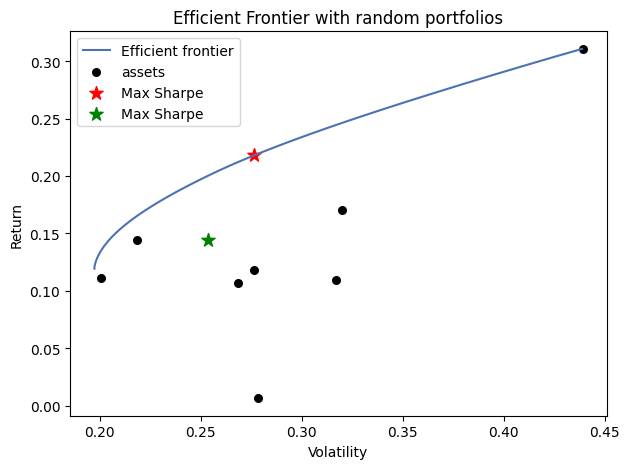

In [6]:
# Calculo de la optimizacion de un portafolio con la libreria pyfolio

mu = retornos_anuales
S = covarianzas

# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Find and plot the tangency portfolio
ax.scatter(consolidado_performance.mean(axis=1)[1], consolidado_performance.mean(axis=1)[0], marker="*", s=100, c="g", label="Max Sharpe")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

## Comparativa perfomance Optimizacion media-varianza y optimizacion por algoritmo genetico

In [7]:
# Pesos que que maximizan la tasa de sharpe en el algoritmo genetico en 10 experimentos
pesos

,iteracion 0,iteracion 1,iteracion 2,iteracion 3,iteracion 4,iteracion 5,iteracion 6,iteracion 7,iteracion 8,iteracion 9
XLE,0.136617,0.062314,0.035432,0.005074,0.048253,0.252724,0.106776,0.078581,0.049778,0.017088
XLF,0.074813,0.159701,0.192196,0.084836,0.156072,0.086660,0.074660,0.206875,0.128864,0.395229
XLV,0.028878,0.254244,0.156951,0.100877,0.132873,0.190575,0.042319,0.072589,0.397303,0.048127
XLK,0.209582,0.148683,0.107143,0.085130,0.102916,0.070115,0.155229,0.231566,0.101098,0.091069
XLU,0.206868,0.125542,0.037326,0.039131,0.124683,0.057147,0.127158,0.188609,0.075078,0.042906
XLI,0.087151,0.120483,0.067031,0.111618,0.005245,0.118977,0.123438,0.027920,0.095518,0.159153
XLP,0.060834,0.095719,0.353266,0.247967,0.236995,0.042431,0.167586,0.049321,0.124951,0.145937
XLC,0.195446,0.033315,0.050796,0.325360,0.192964,0.181402,0.202853,0.144876,0.027371,0.100891


In [8]:
# performance de los 10 experimentos
consolidado_performance

,iteracion 0,iteracion 1,iteracion 2,iteracion 3,iteracion 4,iteracion 5,iteracion 6,iteracion 7,iteracion 8,iteracion 9
Retorno,0.131462,0.144955,0.148371,0.139794,0.150253,0.11121,0.129192,0.161275,0.136202,0.193915
Volatilidad,0.24324,0.264252,0.258354,0.230149,0.25225,0.241794,0.233709,0.265662,0.269545,0.277707
Sharpe Ratio,0.400683,0.419885,0.442691,0.459676,0.460864,0.319322,0.407311,0.479086,0.379165,0.575839


In [9]:
#comparativa del performance optimizacion media-varianza y la media de los 10 esperimentos con el algoritmop genetico

data = {'Media Varianza': ef2.portfolio_performance(),
        'Algoritmo Genetico': consolidado_performance.mean(axis=1).tolist()
        }
df = pd.DataFrame(data, index = ['Retorno','Volatilidad','Sharpe Ratio'])
df['dif'] = df['Media Varianza']-df['Algoritmo Genetico']
df

,Media Varianza,Algoritmo Genetico,dif
Retorno,0.217825,0.144663,0.073162
Volatilidad,0.276300,0.253666,0.022634
Sharpe Ratio,0.715979,0.434452,0.281527
